# Labor Parktikum 2

In [34]:
# Vorbereitung zur Datenverarbeitung

import pandas as pd
import numpy as np
import scipy.signal as sc 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from scipy.signal import butter, filtfilt, find_peaks
import neurokit2 as nk
import os
from Lab2Functions import decg_peaks, d_ecg_peaks, Rwave_peaks

#Daten Einlesen:
dataBTOM = pd.read_csv('data/BelastungEKGTOM.csv', sep='\t')
dataRTOM = pd.read_csv('data/RuheEKGTOM.csv', sep='\t')
dataRGEORG = pd.read_csv('data/RuheEKGGEORG.csv', sep='\t')
dataALEX = pd.read_csv('data/RuheEKGALEX.csv', sep='\t')
dataRAMELIE = pd.read_csv('data/RuheEKGAMELIE.csv', sep='\t')

#Spalten benennen:
dataBTOM.columns = ['EKG', 'Time']
dataRTOM.columns = ['EKG', 'Time']
dataRGEORG.columns = ['EKG', 'Time']
dataRAMELIE.columns = ['EKG', 'Time']
dataALEX.columns = ['EKG', 'Time']

# Filtern der Daten
Wn = 0.10 
b, a = sc.butter(4, Wn, 'low', analog=False)

#Ruhe EKG TOM:
fdataRTOM = filtfilt(b, a, dataRTOM['EKG'])

#Ruhe EKG GEORG:
fdataRGEORG = filtfilt(b, a, dataRGEORG['EKG'])

#Ruhe EKG AMELIE:
fdataRAMELIE = filtfilt(b, a, dataRAMELIE['EKG'])

#Ruhe EKG ALEX:
fdataALEX = filtfilt(b, a, dataALEX['EKG'])

## Aufgabe 3

Führen Sie Aufgabe 1 Teil 4: Experiment in Ruhe für jeden Teilnehmer Ihrer Gruppe aus und plotten Sie 5 Sekunden der gefilterten Daten. Markieren Sie für einen Teilnehmer die P-Welle, den QRS-Komplex und die T-Welle im Plot. Beschreiben Sie das physiologische Phänomen, welches für die jeweiligen elektrischen Signale des EKGs verantwortlich ist.

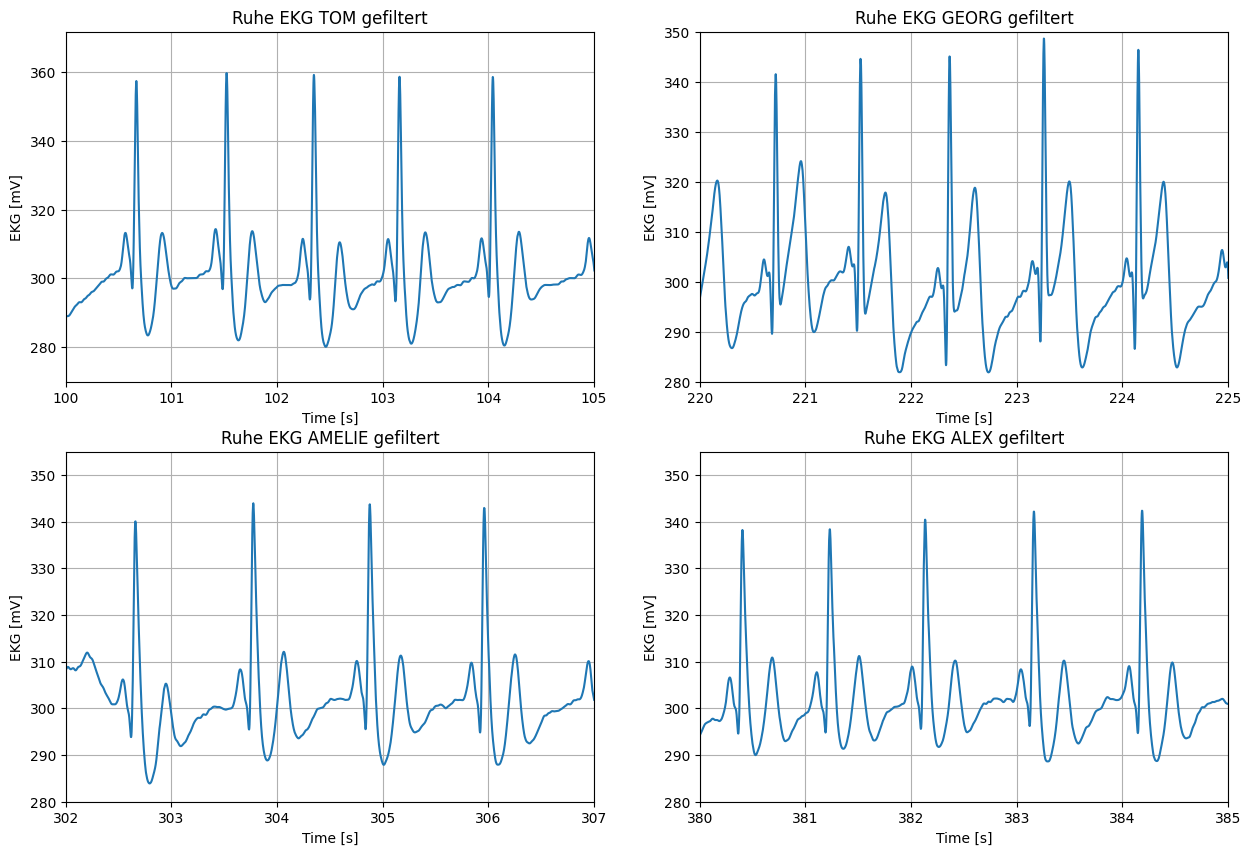

In [35]:
# Plot der gefilterten Daten für 5 Sekunden im Format 2x2

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Ruhe EKG TOM
axs[0, 0].plot(dataRTOM['Time']/1000, fdataRTOM)
axs[0, 0].set_xlim(100, 105)
axs[0, 0].set_title('Ruhe EKG TOM gefiltert')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('EKG [mV]')
axs[0, 0].grid()

# Ruhe EKG GEORG
axs[0, 1].plot(dataRGEORG['Time']/1000, fdataRGEORG)
axs[0, 1].set_xlim(220, 225)
axs[0, 1].set_ylim(280, 350)
axs[0, 1].set_title('Ruhe EKG GEORG gefiltert')
axs[0, 1].set_xlabel('Time [s]')
axs[0, 1].set_ylabel('EKG [mV]')
axs[0, 1].grid()

# Ruhe EKG AMELIE
axs[1, 0].plot(dataRAMELIE['Time']/1000, fdataRAMELIE)
axs[1, 0].set_xlim(302, 307)
axs[1, 0].set_ylim(280, 355)
axs[1, 0].set_title('Ruhe EKG AMELIE gefiltert')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('EKG [mV]')
axs[1, 0].grid()

# Ruhe EKG ALEX
axs[1, 1].plot(dataALEX['Time']/1000, fdataALEX)
axs[1, 1].set_xlim(380, 385)
axs[1, 1].set_ylim(280, 355)
axs[1, 1].set_title('Ruhe EKG ALEX gefiltert')
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('EKG [mV]')
axs[1, 1].grid()

plt.show()

## Aufgabe 5

Plotten Sie etwa 5 Sekunden des EKG-Signals vom Experiment in Ruhe von einem der Teilnehmer (gefiltert). Nutzen Sie die Ergebnisse der PeakSuche-Funktion, um die R-Zacken im Plot zu labeln.

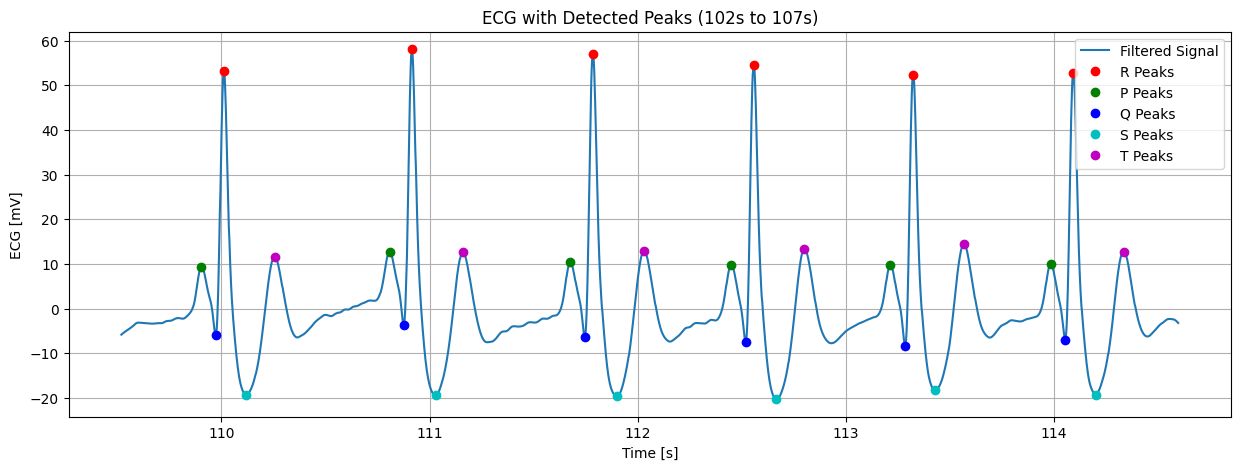

In [86]:
import numpy as np
import scipy.signal as sc
import matplotlib.pyplot as plt
import neurokit2 as nk


def bandpass_filter(sig, lowcut, highcut, fs):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sc.butter(1, [low, high], btype='band')
    return sc.filtfilt(b, a, sig)

fs = 500  # Sampling rate
filtered_signal = bandpass_filter(fdataRTOM, 0.5, 50, fs)

# Detect R-peaks
_, r_peaks = nk.ecg_peaks(fdataRTOM, sampling_rate=fs)

# Define start and end time for plotting
start_time = 102
end_time = start_time + 5
start_idx = int(start_time * fs)
end_idx = int(end_time * fs)

signal_window = filtered_signal[start_idx:end_idx]
time_window = dataRTOM['Time'][start_idx:end_idx] / 1000

# We'll store final detected peaks
p_peaks = []
q_peaks = []
s_peaks = []
t_peaks = []

# Convert times to samples for relative searches
def ms_to_samples(ms):
    return int((ms/1000) * fs)

for i in range(1, len(r_peaks['ECG_R_Peaks']) - 1):
    r_loc = r_peaks['ECG_R_Peaks'][i]
    # To find Q and S, we assume Q and R are correct as per your statement
    # Let's re-detect Q around R more systematically:
    
    # Search window for Q (50ms before R): Q is just before R as a negative deflection
    q_search_window_start = max(r_loc - ms_to_samples(50), 0)
    q_search_window_end = r_loc
    q_segment = filtered_signal[q_search_window_start:q_search_window_end]
    if len(q_segment) > 0:
        # Q is a local minimum before R
        q_rel_idx, _ = sc.find_peaks(-q_segment)
        if len(q_rel_idx) > 0:
            # Take the largest negative peak (lowest point)
            q_min_idx = q_rel_idx[np.argmin(q_segment[q_rel_idx])] 
            q_loc = q_search_window_start + q_min_idx
        else:
            q_loc = None
    else:
        q_loc = None
    
    # If Q is found, mark it
    q_peaks.append(q_loc)
    
    # P peak: occur before Q.
    # Let's search in a window from Q-120ms to Q-20ms before Q
    # (Adjust these as needed)
    if q_loc is not None:
        p_search_start = max(q_loc - ms_to_samples(120), 0)
        p_search_end = q_loc - ms_to_samples(20)
        if p_search_end > p_search_start:
            p_segment = filtered_signal[p_search_start:p_search_end]
            if len(p_segment) > 0:
                # P is often a small positive wave before Q
                # Find a local maximum in that segment
                p_rel_idx, _ = sc.find_peaks(p_segment)
                if len(p_rel_idx) > 0:
                    # Choose the highest peak as P
                    p_max_idx = p_rel_idx[np.argmax(p_segment[p_rel_idx])]
                    p_loc = p_search_start + p_max_idx
                else:
                    p_loc = None
            else:
                p_loc = None
        else:
            p_loc = None
    else:
        p_loc = None
    
    p_peaks.append(p_loc)
    
    # S peak: after R
    # Typically S occurs shortly after R (within 40ms)
    s_search_start = r_loc
    s_search_end = min(r_loc + ms_to_samples(500), len(filtered_signal))
    s_segment = filtered_signal[s_search_start:s_search_end]
    if len(s_segment) > 0:
        # S is a negative deflection after R
        # By using `find_peaks(-s_segment)`, we look for minima in the original signal.
        s_rel_idx, _ = sc.find_peaks(-s_segment)
        if len(s_rel_idx) > 0:
            # Pick the index of the lowest point
            s_min_idx = s_rel_idx[np.argmin(s_segment[s_rel_idx])]
            s_loc = s_search_start + s_min_idx
        else:
            s_loc = None
    else:
        s_loc = None
    
    s_peaks.append(s_loc)
    
    # T peak: occurs later, let's say 200ms after R to 400ms after R
    # Adjust as needed based on your data.
    t_search_start = r_loc + ms_to_samples(200)
    t_search_end = min(r_loc + ms_to_samples(400), len(filtered_signal))
    if s_loc is not None and s_loc > r_loc:
        # We can also start after S if you prefer, but let's use 200ms after R as a baseline
        # If you want after S, you could do max(s_loc+ms_to_samples(50), t_search_start)
        t_search_start = max(t_search_start, s_loc + ms_to_samples(50))
    t_segment = filtered_signal[t_search_start:t_search_end]
    if len(t_segment) > 0:
        # T is a positive peak usually
        t_rel_idx, _ = sc.find_peaks(t_segment)
        if len(t_rel_idx) > 0:
            # Choose the highest peak for T
            t_max_idx = t_rel_idx[np.argmax(t_segment[t_rel_idx])]
            t_loc = t_search_start + t_max_idx
        else:
            t_loc = None
    else:
        t_loc = None

    t_peaks.append(t_loc)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time_window, signal_window, label='Filtered Signal')
ax.set_title(f'ECG with Detected Peaks ({start_time}s to {end_time}s)')
ax.set_xlabel('Time [s]')
ax.set_ylabel('ECG [mV]')
ax.grid()

# R peaks in window
r_peaks_window = [r for r in r_peaks['ECG_R_Peaks'] if start_idx <= r < end_idx]
ax.plot(dataRTOM['Time'][r_peaks_window]/1000, filtered_signal[r_peaks_window], 'ro', label='R Peaks')

p_peaks_window = [p for p in p_peaks if p is not None and start_idx <= p < end_idx]
q_peaks_window = [q for q in q_peaks if q is not None and start_idx <= q < end_idx]
s_peaks_window = [s for s in s_peaks if s is not None and start_idx <= s < end_idx]
t_peaks_window = [t for t in t_peaks if t is not None and start_idx <= t < end_idx]

ax.plot(dataRTOM['Time'][p_peaks_window]/1000, filtered_signal[p_peaks_window], 'go', label='P Peaks')
ax.plot(dataRTOM['Time'][q_peaks_window]/1000, filtered_signal[q_peaks_window], 'bo', label='Q Peaks')
ax.plot(dataRTOM['Time'][s_peaks_window]/1000, filtered_signal[s_peaks_window], 'co', label='S Peaks')
ax.plot(dataRTOM['Time'][t_peaks_window]/1000, filtered_signal[t_peaks_window], 'mo', label='T Peaks')

ax.legend()
plt.show()


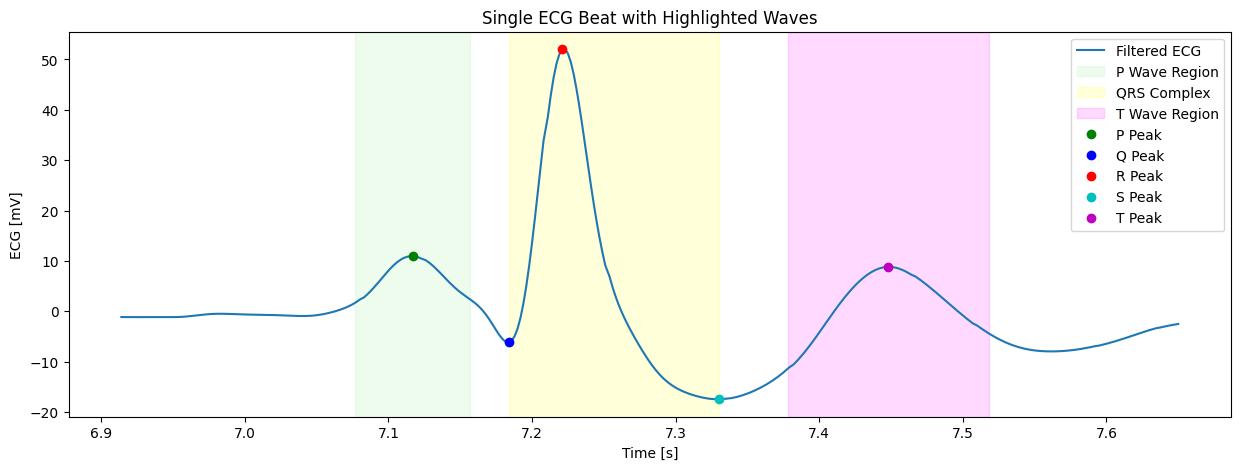

In [96]:
# Choose which beat to display
beat_idx = 0  # for example, display the first detected beat

# Extract peak indices for this beat
# Note: Ensure that your p_peaks, q_peaks, s_peaks, t_peaks indices align with the R peaks
p_loc = p_peaks[beat_idx]
q_loc = q_peaks[beat_idx]
s_loc = s_peaks[beat_idx]
t_loc = t_peaks[beat_idx]

# For R, depending on your indexing, you might need to be careful:
# If your R peak list corresponds directly (e.g. same indexing), do this:
r_loc = r_peaks['ECG_R_Peaks'][beat_idx+1]  # +1 if p,q,s,t indexing started at second R

# Define a helper to convert ms to samples
def ms_to_samples(ms, fs=500):
    return int((ms/1000) * fs)

# Determine a plotting window around the beat
# For example: 200ms before P wave to 200ms after T wave
start_view = max(p_loc - ms_to_samples(200), 0)
end_view = min(t_loc + ms_to_samples(200), len(filtered_signal))

time_segment = dataRTOM['Time'][start_view:end_view]/1000
ecg_segment = filtered_signal[start_view:end_view]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(time_segment, ecg_segment, label='Filtered ECG')

# Now highlight the areas of interest.
# For the P wave, we only have a peak point. Let's highlight a small region around it, say ±40ms
ax.axvspan((dataRTOM['Time'][p_loc]/1000 - 0.04), (dataRTOM['Time'][p_loc]/1000 + 0.04),
           color='lightgreen', alpha=0.15, label='P Wave Region')

# Highlight the Q to S region (QRS complex)
ax.axvspan(dataRTOM['Time'][q_loc]/1000, dataRTOM['Time'][s_loc]/1000,
           color='yellow', alpha=0.15, label='QRS Complex')

# For the T wave, also highlight a small region around it, say ±70ms
ax.axvspan((dataRTOM['Time'][t_loc]/1000 - 0.07), (dataRTOM['Time'][t_loc]/1000 + 0.07),
           color='magenta', alpha=0.15, label='T Wave Region')

# Mark the individual peaks
ax.plot(dataRTOM['Time'][p_loc]/1000, filtered_signal[p_loc], 'go', label='P Peak')
ax.plot(dataRTOM['Time'][q_loc]/1000, filtered_signal[q_loc], 'bo', label='Q Peak')
ax.plot(dataRTOM['Time'][r_loc]/1000, filtered_signal[r_loc], 'ro', label='R Peak')
ax.plot(dataRTOM['Time'][s_loc]/1000, filtered_signal[s_loc], 'co', label='S Peak')
ax.plot(dataRTOM['Time'][t_loc]/1000, filtered_signal[t_loc], 'mo', label='T Peak')

ax.set_title('Single ECG Beat with Highlighted Waves')
ax.set_xlabel('Time [s]')
ax.set_ylabel('ECG [mV]')
ax.grid(False)
ax.legend()
plt.show()
